In [16]:
from scipy.stats import poisson
import matplotlib.pyplot as plt
import numpy as np
from numpy import exp, sin, cos, sqrt, real, imag, argmax, argmin
from scipy.special import iv, i0
from scipy.integrate import quad
import tqdm
%matplotlib notebook

In [2]:
P = 0.04 # mW
la1 = 20823.89228823*P  # cps
la2 = 160507.64200232*P # cps
ga1 = 3872.39255739*P*P    # Hz
ga2 = 24142.64150491 *P*P  # Hz
TR = 11e-3  # Read out time is second
print( ga2/(ga1+ga2), ga1/(ga1+ga2) )

0.8617744833442448 0.1382255166557553


In [123]:
def integrand_Pn_even(t,n,la1,la2,ga1,ga2,TR):
    return exp((ga1-ga2)*t-ga1*TR)*sqrt(ga1*ga2*t/(TR-t))*iv(1,2*sqrt(ga1*ga2*t*(TR-t)))*poisson.pmf(n, la2*t+la1*(TR-t))
    
def Pn_even(n,la1,la2,ga1,ga2,TR): # probability to emit n photons for even jumps FROM LEVEL 2 TO LEVEL 1
    return quad(integrand_Pn_even, 0, TR, args=(n,la1,la2,ga1,ga2,TR))[0] + exp(-ga2*TR)*poisson.pmf(n, la2*TR)

##########################################################################################################
def integrand_Pn_odd(t,n,la1,la2,ga1,ga2,TR):
    return exp((ga1-ga2)*t-ga1*TR)*ga2*iv(0,2*sqrt(ga1*ga2*t*(TR-t)))*poisson.pmf(n, la2*t+la1*(TR-t))
    
def Pn_odd(n,la1,la2,ga1,ga2,TR): # probability to emit n photons for odd jumps FROM LEVEL 2 TO LEVEL 1
    return quad(integrand_Pn_odd, 0, TR, args=(n,la1,la2,ga1,ga2,TR))[0]

###############################################################################################################
def Pn_1(n):
    return poisson.pmf(n, la1*TR)
#----------------------------------
def Pn_2(n):
    return poisson.pmf(n, la2*TR)
##############################################################################################################
## finding intersection of two curves as threshold for fidelity
def n_th(arr1,arr2):
    arr = arr1 - arr2
    index = np.where(np.sign(arr[:-1]) != np.sign(arr[1:]))[0][0] + 1
    if np.abs(arr[index-1]) > np.abs(arr[index]): return index
    elif (index-1)!=0: return index-1 
    else: return index
###############################################################################################################
def Distribution(la1,la2,ga1,ga2,TR,p1,p2,m=0):
    pn_i1,pn_i2,pn_f1,pn_f2 =np.array([]), np.array([]), np.array([]), np.array([])
    N = np.arange(poisson.ppf(0.0001, la1*TR),poisson.ppf(0.9999, la2*TR)) ### trancating the fidelity integral
    for n in N:
        even_from2 = Pn_even(n,la1,la2,ga1,ga2,TR)
        odd_from2 = Pn_odd(n,la1,la2,ga1,ga2,TR)
        even_from1 = Pn_even(n,la2,la1,ga2,ga1,TR)
        odd_from1 = Pn_odd(n,la2,la1,ga2,ga1,TR)
        
        pn_i1 = np.append(pn_i1, even_from1+odd_from1)        # probab. to emit n photons conditioned initial state 1
        pn_i2 = np.append(pn_i2, even_from2+odd_from2)        # probab. to emit n photons conditioned initial state 2
        pn_f1 = np.append(pn_f1, p2*odd_from2 +p1*even_from1) # probab. to emit n photons conditioned final state 1
        pn_f2 = np.append(pn_f2, p2*even_from2 +p1*odd_from1) # probab. to emit n photons conditioned final state 2
    #pn_i1, pn_i2 = pn_i1/np.trapz(pn_i1), pn_i2/np.trapz(pn_i2)
    pn_f1, pn_f2 = pn_f1/np.sum(pn_f1), pn_f2/np.sum(pn_f2)
    n_th_i, n_th_f = n_th(pn_i1,pn_i2)+m, n_th(pn_f1,pn_f2)+m # m is shift of threshold
    F_i = 1 - np.sum(pn_i2[0:n_th_i+1]) - np.sum(pn_i1[n_th_i:])
    F_f = 1 - np.sum(pn_f2[0:n_th_f+1]) - np.sum(pn_f1[n_th_f:])
    pn_1 = poisson.pmf(N, la1*TR)
    pn_2 = poisson.pmf(N, la2*TR)
    return [N, pn_1,pn_2, pn_i1,pn_i2, pn_f1, pn_f2, F_i, F_f, n_th_i, n_th_f]
###########################################################################################################
def Fidelity_distinct(la1,la2,ga1,ga2,TR,p1,p2):
    pn_i1,pn_i2,pn_f1,pn_f2 =np.array([]), np.array([]), np.array([]), np.array([])
    N = np.arange(poisson.ppf(0.0001, la1*TR),poisson.ppf(0.9999, la2*TR)) ### trancating the fidelity integral
    for n in N:
        even_from2 = Pn_even(n,la1,la2,ga1,ga2,TR)
        odd_from2 = Pn_odd(n,la1,la2,ga1,ga2,TR)
        even_from1 = Pn_even(n,la2,la1,ga2,ga1,TR)
        odd_from1 = Pn_odd(n,la2,la1,ga2,ga1,TR)
        
        pn_i1 = np.append(pn_i1, even_from1+odd_from1)        # probab. to emit n photons conditioned initial state 1
        pn_i2 = np.append(pn_i2, even_from2+odd_from2)        # probab. to emit n photons conditioned initial state 2
        pn_f1 = np.append(pn_f1, p2*odd_from2 +p1*even_from1) # probab. to emit n photons conditioned final state 1
        pn_f2 = np.append(pn_f2, p2*even_from2 +p1*odd_from1) # probab. to emit n photons conditioned final state 2
    #pn_i1, pn_i2 = pn_i1/np.sum(pn_i1), pn_i2/np.sum(pn_i2)
    pn_f1, pn_f2 = pn_f1/np.sum(pn_f1), pn_f2/np.sum(pn_f2)
    n_th_i, n_th_f = n_th(pn_i1,pn_i2), n_th(pn_f1,pn_f2) # m is shift of threshold
    F_i = 1 - np.sum(pn_i2[0:n_th_i+1]) - np.sum(pn_i1[n_th_i:])
    F_f = 1 - np.sum(pn_f2[0:n_th_f+1]) - np.sum(pn_f1[n_th_f:])
    return [F_i,F_f,n_th_i, n_th_f]
###########################################################################################################
def Fidelity_state2(la1,la2,ga1,ga2,TR,p1,p2,m=0):
    pn_i1,pn_i2,pn_f1,pn_f2 =np.array([]), np.array([]), np.array([]), np.array([])
    N = np.arange(poisson.ppf(0.0001, la1*TR),poisson.ppf(0.9999, la2*TR)) ### trancating the fidelity integral
    for n in N:
        even_from2 = Pn_even(n,la1,la2,ga1,ga2,TR)
        odd_from2 = Pn_odd(n,la1,la2,ga1,ga2,TR)
        even_from1 = Pn_even(n,la2,la1,ga2,ga1,TR)
        odd_from1 = Pn_odd(n,la2,la1,ga2,ga1,TR)
        
        pn_i1 = np.append(pn_i1, even_from1+odd_from1)        # probab. to emit n photons conditioned initial state 1
        pn_i2 = np.append(pn_i2, even_from2+odd_from2)        # probab. to emit n photons conditioned initial state 2
        pn_f1 = np.append(pn_f1, p2*odd_from2 +p1*even_from1) # probab. to emit n photons conditioned final state 1
        pn_f2 = np.append(pn_f2, p2*even_from2 +p1*odd_from1) # probab. to emit n photons conditioned final state 2
    #pn_i1, pn_i2 = pn_i1/np.sum(pn_i1), pn_i2/np.sum(pn_i2)
    pn_f1, pn_f2 = pn_f1/np.sum(pn_f1), pn_f2/np.sum(pn_f2)
    n_th_i, n_th_f = n_th(pn_i1,pn_i2)+m, n_th(pn_f1,pn_f2)+m # m is shift of threshold
    new_F_i = (1 - np.sum(pn_i2[0:n_th_i+1]) - np.sum(pn_i1[n_th_i:]))*(1 - np.sum(pn_i1[n_th_i:]))
    new_F_f = (1 - np.sum(pn_f2[0:n_th_f+1]) - np.sum(pn_f1[n_th_f:]))*(1 - np.sum(pn_f1[n_th_f:]))
    F_i = 1 - np.sum(pn_i1[n_th_i:])
    F_f = 1 - np.sum(pn_f1[n_th_f:])
    return [F_i,F_f,n_th_i, n_th_f, new_F_i, new_F_f]
###########################################################################################################

0.25 0.75
0.999999960840295 0.9999037888674894


<IPython.core.display.Javascript object>


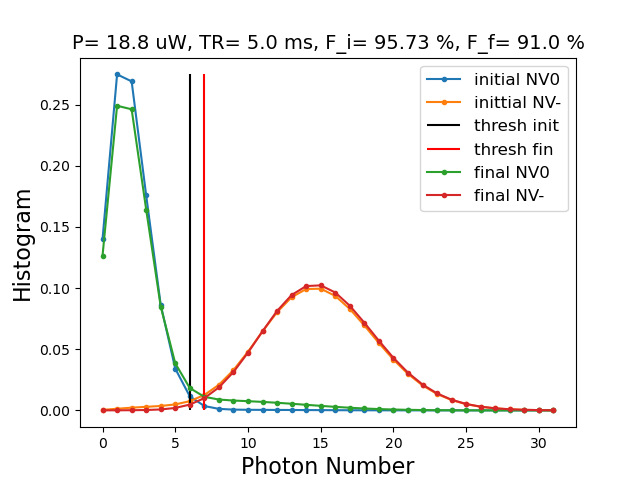

Text(0, 0.5, 'Histogram')

In [124]:
P = 0.0188 # mW
la1 = 20823.89228823*P  # cps
la2 = 160507.64200232*P # cps
ga1 = 3872.39255739*P*P    # Hz
ga2 = 24142.64150491 *P*P  # Hz
TR = 5e-3  # Read out time is second
#p2 = ga1/(ga1+ga2)
p2 = 0.75
p1 = 1-p2
print(p1,p2)
[N, pn_1,pn_2, pn_i1,pn_i2, pn_f1, pn_f2, F_i, F_f, n_th_i, n_th_f] = Distribution(la1,la2,ga1,ga2,TR,p1,p2,m=0)
print(np.sum(pn_i1),np.sum(pn_i2))
plt.figure(dpi=100)
#plt.plot(N, pn_1, '-o', ms=3, label='NV0')
#plt.plot(N, pn_2, '-o', ms=3, label='NV-')
plt.plot(N, pn_i1, '-o', ms=3, label='initial NV0')
plt.plot(N, pn_i2, '-o', ms=3, label='inittial NV-')
plt.vlines(n_th_i+min(N),ymin=0, ymax=max(pn_i1), color='black',label='thresh init')
plt.vlines(n_th_f+min(N),ymin=0, ymax=max(pn_i1), color='red',label='thresh fin')
plt.plot(N, pn_f1, '-o', ms=3, label='final NV0')
plt.plot(N, pn_f2, '-o', ms=3, label='final NV-')
plt.title('P= {} uW'.format(1e-3*round(P*1e6))+', TR= {} ms'.format(round(TR*1e5)*1e-2)
          +', F_i= {} %'.format(round(F_i*1e4)*1e-2)+', F_f= {} %'.format(round(F_f*1e3)*1e-1), fontsize=14)
plt.legend(fontsize=12)
plt.xlabel('Photon Number', fontsize=16)
plt.ylabel('Histogram', fontsize=16)

# 1D Fidelity as a function of power

In [125]:
F_is,F_fs=np.array([]), np.array([])
PP = np.linspace(0.01,0.09,20)
TR = 5e-3
#p2=ga1/(ga1+ga2)
p2 = 0.7 
for P in tqdm.tqdm_notebook(PP):
    la1 = 20823.89228823*P  # cps
    la2 = 160507.64200232*P # cps
    ga1 = 3872.39255739*P*P   # Hz
    ga2 = 24142.64150491*P*P  # Hz
    [F_i,F_f,n_th_i, n_th_f] = Fidelity_distinct(la1,la2,ga1,ga2,TR,1-p2,p2)
    F_is = np.append(F_is, F_i)
    F_fs = np.append(F_fs, F_f)

C:\Users\majid\AppData\Local\Temp\ipykernel_14624\2116690212.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for P in tqdm.tqdm_notebook(PP):


  0%|          | 0/20 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


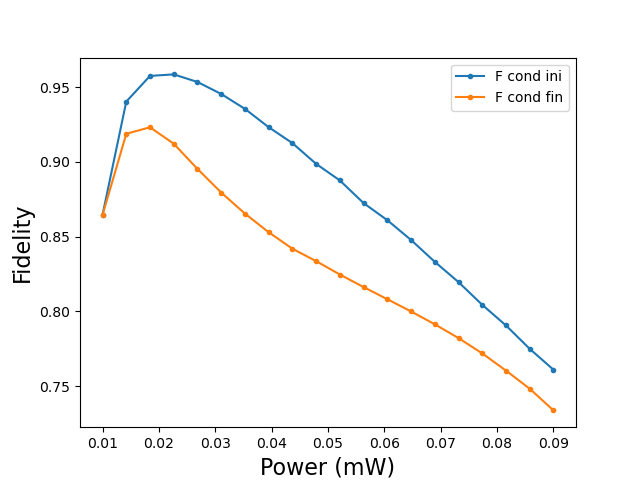

In [126]:
plt.figure()
plt.plot(PP, F_is, '-o', ms=3, label='F cond ini')
plt.plot(PP, F_fs, '-o', ms=3, label='F cond fin')
#plt.legend(fontsize=12)
plt.xlabel('Power (mW)', fontsize=16)
plt.ylabel('Fidelity', fontsize=16)
plt.legend()

# 2D Fidelity as a function of power and readout time

In [139]:
F_2d_i, F_2d_f = [], []
PP = np.linspace(0.01,0.1,12)
p1,p2 = 0.25, 0.75 
for P in tqdm.tqdm_notebook(PP):
    la1 = 20823.89228823*P  # cps
    la2 = 160507.64200232*P # cps
    ga1 = 3872.39255739*P*P   # Hz
    ga2 = 24142.64150491*P*P  # Hz
    
    F_is,F_fs=[], []
    TTR = np.linspace(0.5e-3,5e-3,20)
    for TR in TTR:
        [F_i,F_f,n_th_i, n_th_f] = Fidelity_distinct(la1,la2,ga1,ga2,TR,p1,p2)
        F_is.append(F_i)
        F_fs.append(F_f)
    
    F_2d_i.append(F_is)
    F_2d_f.append(F_fs)
F_2d_i, F_2d_f = np.array(F_2d_i), np.array(F_2d_f)

C:\Users\majid\AppData\Local\Temp\ipykernel_14624\2709798042.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for P in tqdm.tqdm_notebook(PP):


  0%|          | 0/12 [00:00<?, ?it/s]

Max Fidelity init= 0.957523333018671
Optimum power init = 18.18181818181818 uW
Optimum time init= 5.0 ms


<IPython.core.display.Javascript object>


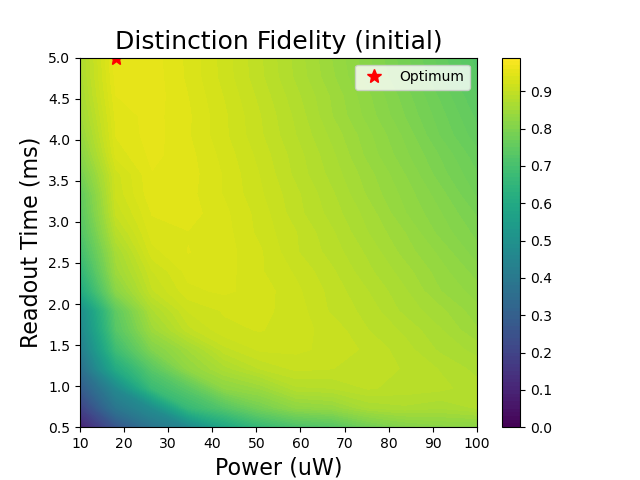

Max Fidelity final= 0.9104423875873027
Optimum power = 18.18181818181818 uW
Optimum time = 5.0 ms


<IPython.core.display.Javascript object>


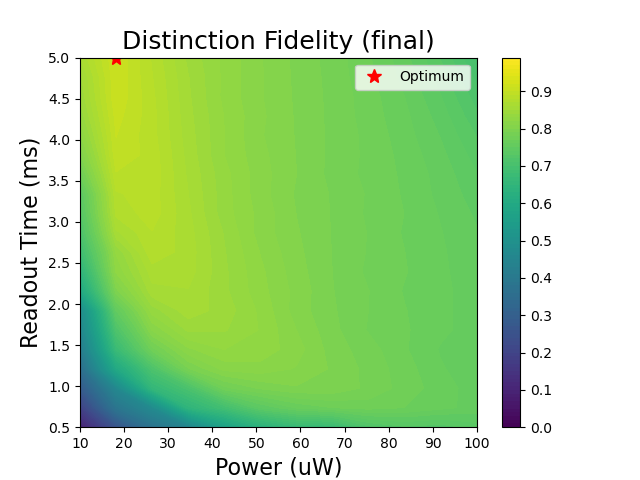

In [140]:
time,power=np.meshgrid(TTR, PP)
opt_F_i, opt_F_f = np.max(F_2d_i),  np.max(F_2d_f)
print("Max Fidelity init= {}".format(opt_F_i))
#########################################################
result=np.where(F_2d_i == np.amax(F_2d_i))
listOfCordinates = list(zip(result[0], result[1]))
for cord in listOfCordinates:
    if F_2d_i[cord[0]][cord[1]]==np.max(F_2d_i):
        opt_p_i = power[cord[0]][cord[1]]
        opt_t_i = time[cord[0]][cord[1]]
        print('Optimum power init = {} uW'.format(opt_p_i*1000))
        print('Optimum time init= {} ms'.format(opt_t_i*1000))
    else: print('max did not calculated correctly')

#############################################################################
   
plt.figure(dpi=100)
plt.contourf(power*1000, time*1000, F_2d_i,np.arange(0.0, 1, .01))
plt.title('Distinction Fidelity (initial)', fontsize =18)
plt.plot(opt_p_i*1000, opt_t_i*1000, '*', ms=10, color='red', label='Optimum')
plt.xlabel('Power (uW)', fontsize=16)
plt.ylabel('Readout Time (ms)', fontsize =16)
#plt.yscale("log")
plt.colorbar()
plt.legend()
#plt.savefig("F_distinguish_initial_broad.png",dpi=150)
###################################################################
print( "Max Fidelity final= {}".format(opt_F_f))
result=np.where(F_2d_f == np.amax(F_2d_f))
listOfCordinates = list(zip(result[0], result[1]))
for cord in listOfCordinates:
    if F_2d_f[cord[0]][cord[1]]==np.max(F_2d_f):
        opt_p_f = power[cord[0]][cord[1]]
        opt_t_f = time[cord[0]][cord[1]]
        print('Optimum power = {} uW'.format(opt_p_f*1000))
        print('Optimum time = {} ms'.format(opt_t_i*1000))
    else: print('max did not calculated correctly')
#######################################################################
plt.figure(dpi=100)
plt.contourf(power*1000, time*1000, F_2d_f,np.arange(0.0, 1, .01))
plt.title('Distinction Fidelity (final)', fontsize =18)
plt.plot(opt_p_f*1000, opt_t_f*1000, '*', ms=10, color='red', label='Optimum')
plt.xlabel('Power (uW)', fontsize=16)
plt.ylabel('Readout Time (ms)', fontsize =16)
plt.colorbar()
plt.legend()
#plt.yscale("log")
#plt.savefig("F_distinguish_final_broad.png",dpi=150)


0.25 0.75


<IPython.core.display.Javascript object>


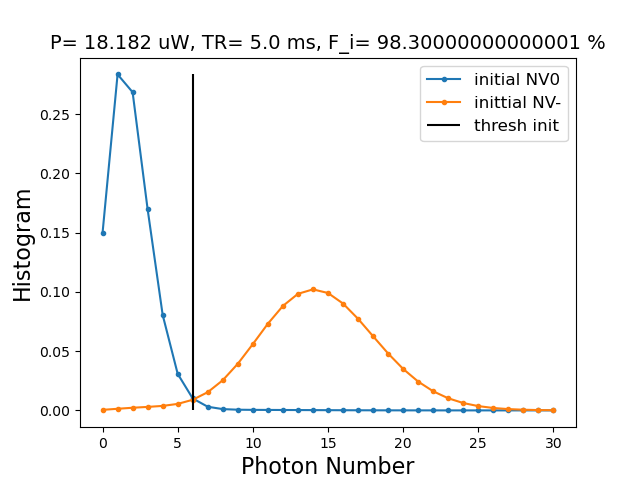

0.25 0.75


<IPython.core.display.Javascript object>


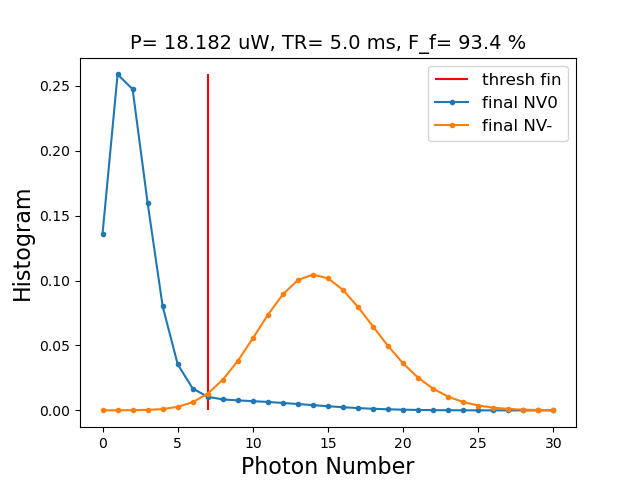

Text(0, 0.5, 'Histogram')

In [141]:
P = opt_p_i # mW
la1 = 20823.89228823*P  # cps
la2 = 160507.64200232*P # cps
ga1 = 3872.39255739*P*P    # Hz
ga2 = 24142.64150491 *P*P  # Hz
TR = opt_t_i  # Read out time is second
#p2 = ga1/(ga1+ga2)
p2 = 0.75
p1 = 1-p2
print(p1,p2)
[N, pn_1,pn_2, pn_i1,pn_i2, pn_f1, pn_f2, F_i, F_f, n_th_i, n_th_f] = Distribution(la1,la2,ga1,ga2,TR,p1,p2,m=0)
[F_i,F_f,n_th_i, n_th_f, new_F_i, new_F_f] = Fidelity_state2(la1,la2,ga1,ga2,TR,p1,p2,m=m)
plt.figure(dpi=100)
#plt.plot(N, pn_1, '-o', ms=3, label='NV0')
#plt.plot(N, pn_2, '-o', ms=3, label='NV-')
plt.plot(N, pn_i1, '-o', ms=3, label='initial NV0')
plt.plot(N, pn_i2, '-o', ms=3, label='inittial NV-')
plt.vlines(n_th_i+min(N),ymin=0, ymax=max(pn_i1), color='black',label='thresh init')
#plt.vlines(n_th_f+min(N),ymin=0, ymax=max(pn_i1), color='red',label='thresh fin')
#plt.plot(N, pn_f1, '-o', ms=3, label='final NV0')
#plt.plot(N, pn_f2, '-o', ms=3, label='final NV-')
plt.title('P= {} uW'.format(1e-3*round(P*1e6))+', TR= {} ms'.format(round(TR*1e5)*1e-2)
          +', F_i= {} %'.format(round(F_i*1e3)*1e-1), fontsize=14)
plt.legend(fontsize=12)
plt.xlabel('Photon Number', fontsize=16)
plt.ylabel('Histogram', fontsize=16)

P = opt_p_f # mW
la1 = 20823.89228823*P  # cps
la2 = 160507.64200232*P # cps
ga1 = 3872.39255739*P*P    # Hz
ga2 = 24142.64150491 *P*P  # Hz
TR = opt_t_f  # Read out time is second
#p2 = ga1/(ga1+ga2)
p2 = 0.75
p1 = 1-p2
print(p1,p2)
[N, pn_1,pn_2, pn_i1,pn_i2, pn_f1, pn_f2, F_i, F_f, n_th_i, n_th_f] = Distribution(la1,la2,ga1,ga2,TR,p1,p2,m=0)
[F_i,F_f,n_th_i, n_th_f, new_F_i, new_F_f] = Fidelity_state2(la1,la2,ga1,ga2,TR,p1,p2,m=m)
plt.figure(dpi=100)
#plt.plot(N, pn_1, '-o', ms=3, label='NV0')
#plt.plot(N, pn_2, '-o', ms=3, label='NV-')
#plt.plot(N, pn_i1, '-o', ms=3, label='initial NV0')
#plt.plot(N, pn_i2, '-o', ms=3, label='inittial NV-')
#plt.vlines(n_th_i+min(N),ymin=0, ymax=max(pn_i1), color='black',label='thresh init')
plt.vlines(n_th_f+min(N),ymin=0, ymax=max(pn_f1), color='red',label='thresh fin')
plt.plot(N, pn_f1, '-o', ms=3, label='final NV0')
plt.plot(N, pn_f2, '-o', ms=3, label='final NV-')
plt.title('P= {} uW'.format(1e-3*round(P*1e6))+', TR= {} ms'.format(round(TR*1e5)*1e-2)
          +', F_f= {} %'.format(round(F_f*1e3)*1e-1), fontsize=14)
plt.legend(fontsize=12)
plt.xlabel('Photon Number', fontsize=16)
plt.ylabel('Histogram', fontsize=16)


# Let's look at Fidelity of NV- state (state 2)

In [337]:
F_2d_i, F_2d_f,new_F_2d_i,new_F_2d_f = [], [],[], []
PP = np.linspace(0.01,0.1,15)
p1,p2 = 0.25, 0.75
m=0
for P in tqdm.tqdm_notebook(PP):
    la1 = 20823.89228823*P  # cps
    la2 = 160507.64200232*P # cps
    ga1 = 3872.39255739*P*P   # Hz
    ga2 = 24142.64150491*P*P  # Hz
    
    F_is,F_fs,new_F_is,new_F_fs=[], [],[], []
    TTR = np.linspace(0.5e-3,5e-3,15)
    for TR in TTR:
        [F_i,F_f,n_th_i, n_th_f, new_F_i, new_F_f] = Fidelity_state2(la1,la2,ga1,ga2,TR,p1,p2,m=m)
        F_is.append(F_i)
        F_fs.append(F_f)
        new_F_is.append(new_F_i)
        new_F_fs.append(new_F_f)
    
    F_2d_i.append(F_is)
    F_2d_f.append(F_fs)
    new_F_2d_i.append(new_F_is)
    new_F_2d_f.append(new_F_fs)
    
F_2d_i, F_2d_f,new_F_2d_i,new_F_2d_f = np.array(F_2d_i), np.array(F_2d_f),np.array(new_F_2d_i), np.array(new_F_2d_f)

C:\Users\majid\AppData\Local\Temp\ipykernel_14624\78716205.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for P in tqdm.tqdm_notebook(PP):


  0%|          | 0/15 [00:00<?, ?it/s]

Max Fidelity init= 0.9889712893214848
Optimum power init = 22.85714285714286 uW
Optimum time init= 4.357142857142858 ms


C:\Users\majid\AppData\Local\Temp\ipykernel_14624\3939536463.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=100)


<IPython.core.display.Javascript object>


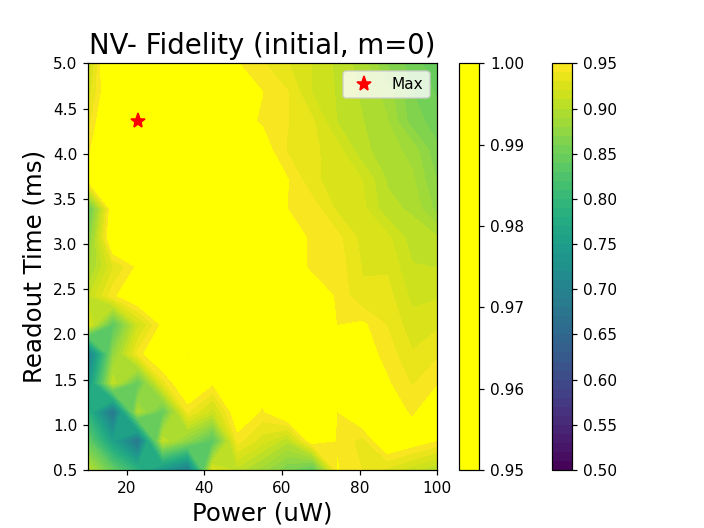

Max Fidelity final= 0.9588508512356781
Optimum power = 10.0 uW
Optimum time = 4.357142857142858 ms


C:\Users\majid\AppData\Local\Temp\ipykernel_14624\3939536463.py:20: UserWarning: linewidths is ignored by contourf
  plt.contourf(power*1000, time*1000,F_2d_i,


<IPython.core.display.Javascript object>


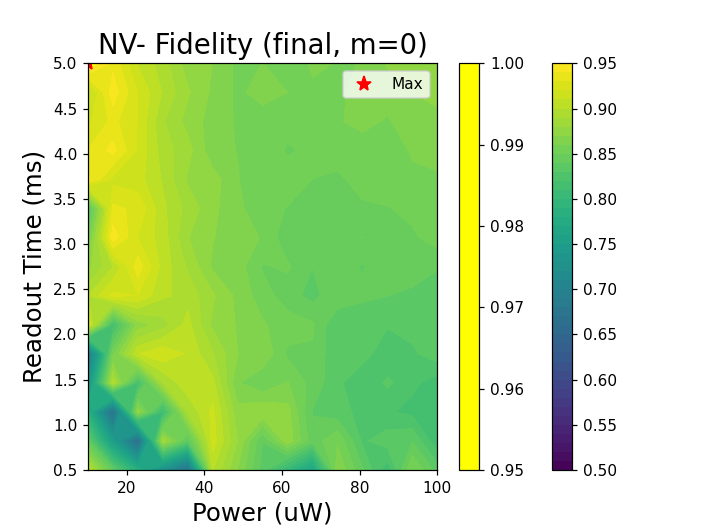

C:\Users\majid\AppData\Local\Temp\ipykernel_14624\3939536463.py:46: UserWarning: linewidths is ignored by contourf
  plt.contourf(power*1000, time*1000,F_2d_f,


In [338]:
time,power=np.meshgrid(TTR, PP)
opt_F_i, opt_F_f = np.max(F_2d_i),  np.max(F_2d_f)
print("Max Fidelity init= {}".format(opt_F_i))
#########################################################
result=np.where(F_2d_i == np.amax(F_2d_i))
listOfCordinates = list(zip(result[0], result[1]))
for cord in listOfCordinates:
    if F_2d_i[cord[0]][cord[1]]==np.max(F_2d_i):
        opt_p_i = power[cord[0]][cord[1]]
        opt_t_i = time[cord[0]][cord[1]]
        print('Optimum power init = {} uW'.format(opt_p_i*1000))
        print('Optimum time init= {} ms'.format(opt_t_i*1000))
    else: print('max did not calculated correctly')

#############################################################################
F_lim=0.95 #### What is your minimum required fidelity
plt.figure(dpi=100)
plt.contourf(power*1000, time*1000, F_2d_i,np.arange(0.5, F_lim+0.01, .01))
plt.colorbar()
plt.contourf(power*1000, time*1000,F_2d_i,
             levels = np.arange(F_lim, 1, .01), colors=('yellow',),linestyles=('-',),linewidths=(3,))
plt.colorbar()
plt.title('NV- Fidelity (initial, m={})'.format(m), fontsize =18)
plt.plot(opt_p_i*1000, opt_t_i*1000, '*', ms=10, color='red', label='Max')
plt.xlabel('Power (uW)', fontsize=16)
plt.ylabel('Readout Time (ms)', fontsize =16)
#plt.yscale("log")
plt.legend()
#plt.savefig("F_distinguish_initial_broad.png",dpi=150)

###################################################################
print( "Max Fidelity final= {}".format(opt_F_f))
result=np.where(F_2d_f == np.amax(F_2d_f))
listOfCordinates = list(zip(result[0], result[1]))
for cord in listOfCordinates:
    if F_2d_f[cord[0]][cord[1]]==np.max(F_2d_f):
        opt_p_f = power[cord[0]][cord[1]]
        opt_t_f = time[cord[0]][cord[1]]
        print('Optimum power = {} uW'.format(opt_p_f*1000))
        print('Optimum time = {} ms'.format(opt_t_i*1000))
    else: print('max did not calculated correctly')
#######################################################################
plt.figure(dpi=100)
plt.contourf(power*1000, time*1000, F_2d_f,np.arange(0.5, F_lim+0.01, .01))
plt.colorbar()
plt.contourf(power*1000, time*1000,F_2d_f,
             levels = np.arange(F_lim, 1, .01), colors=('yellow',),linestyles=('-',),linewidths=(3,))
plt.colorbar()
plt.title('NV- Fidelity (final, m={})'.format(m), fontsize =18)
plt.plot(opt_p_f*1000, opt_t_f*1000, '*', ms=10, color='red', label='Max')
plt.xlabel('Power (uW)', fontsize=16)
plt.ylabel('Readout Time (ms)', fontsize =16)
plt.legend()
#plt.yscale("log")
#plt.savefig("F_distinguish_final_broad.png",dpi=150)


Max Fidelity init= 0.9889712893214848
Optimum power init = 22.85714285714286 uW
Optimum time init= 4.357142857142858 ms


C:\Users\majid\AppData\Local\Temp\ipykernel_14624\3127813189.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=100)


<IPython.core.display.Javascript object>


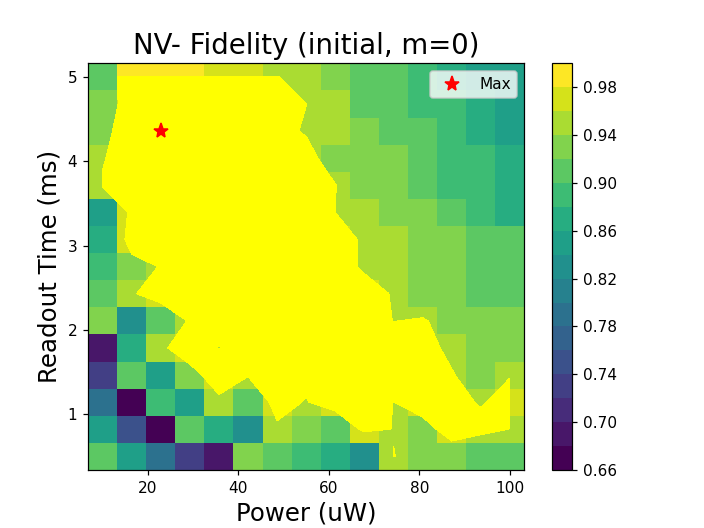

C:\Users\majid\AppData\Local\Temp\ipykernel_14624\3127813189.py:29: UserWarning: linewidths is ignored by contourf
  plt.contourf(power*1000, time*1000,z,


Max Fidelity final= 0.9588508512356781
Optimum power = 10.0 uW
Optimum time = 4.357142857142858 ms


<IPython.core.display.Javascript object>


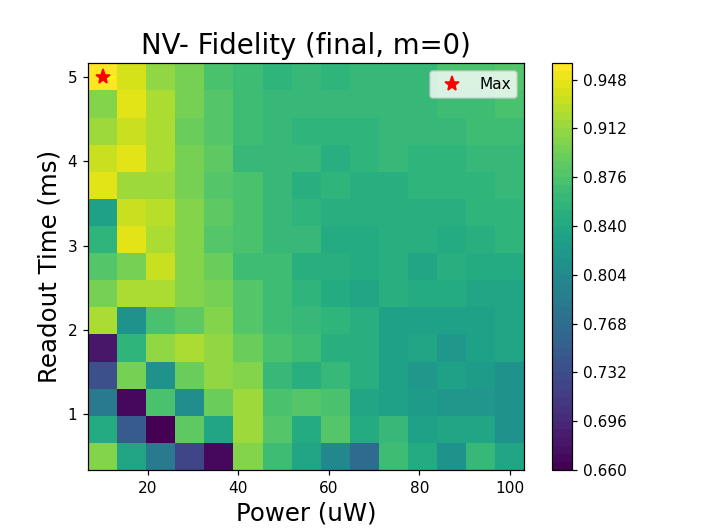

C:\Users\majid\AppData\Local\Temp\ipykernel_14624\3127813189.py:59: UserWarning: linewidths is ignored by contourf
  plt.contourf(power*1000, time*1000,z,


In [339]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

time,power=np.meshgrid(TTR, PP)
opt_F_i, opt_F_f = np.max(F_2d_i),  np.max(F_2d_f)
print("Max Fidelity init= {}".format(opt_F_i))
z=F_2d_i
#########################################################
result=np.where(z == np.amax(z))
listOfCordinates = list(zip(result[0], result[1]))
for cord in listOfCordinates:
    if z[cord[0]][cord[1]]==np.max(z):
        opt_p_i = power[cord[0]][cord[1]]
        opt_t_i = time[cord[0]][cord[1]]
        print('Optimum power init = {} uW'.format(opt_p_i*1000))
        print('Optimum time init= {} ms'.format(opt_t_i*1000))
    else: print('max did not calculated correctly')

#############################################################################
F_lim=0.95 #### What is your minimum required fidelity
plt.figure(dpi=100)
levels = MaxNLocator(nbins=20).tick_values(z.min(), z.max())
cmap = plt.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
plt.pcolormesh(power*1000, time*1000, z, norm=norm)
plt.colorbar()
plt.contourf(power*1000, time*1000,z,
             levels = np.arange(F_lim, 1, .01), colors=('yellow',),linestyles=('-',),linewidths=(3,))
plt.title('NV- Fidelity (initial, m={})'.format(m), fontsize =18)
plt.plot(opt_p_i*1000, opt_t_i*1000, '*', ms=10, color='red', label='Max')
plt.xlabel('Power (uW)', fontsize=16)
plt.ylabel('Readout Time (ms)', fontsize =16)
#plt.yscale("log")
plt.legend()
#plt.savefig("F_distinguish_initial_broad.png",dpi=150)

###################################################################
z=F_2d_f
print( "Max Fidelity final= {}".format(opt_F_f))
result=np.where(z == np.amax(z))
listOfCordinates = list(zip(result[0], result[1]))
for cord in listOfCordinates:
    if z[cord[0]][cord[1]]==np.max(z):
        opt_p_f = power[cord[0]][cord[1]]
        opt_t_f = time[cord[0]][cord[1]]
        print('Optimum power = {} uW'.format(opt_p_f*1000))
        print('Optimum time = {} ms'.format(opt_t_i*1000))
    else: print('max did not calculated correctly')
#######################################################################
F_lim=0.95 #### What is your minimum required fidelity
plt.figure(dpi=100)
levels = MaxNLocator(nbins=50).tick_values(z.min(), z.max())
cmap = plt.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
plt.pcolormesh(power*1000, time*1000, z, norm=norm)
plt.colorbar()
plt.contourf(power*1000, time*1000,z,
             levels = np.arange(F_lim, 1, .01), colors=('yellow',),linestyles=('-',),linewidths=(3,))
plt.title('NV- Fidelity (final, m={})'.format(m), fontsize =18)
plt.plot(opt_p_f*1000, opt_t_f*1000, '*', ms=10, color='red', label='Max')
plt.xlabel('Power (uW)', fontsize=16)
plt.ylabel('Readout Time (ms)', fontsize =16)
plt.legend()
#plt.yscale("log")
#plt.savefig("F_distinguish_final_broad.png",dpi=150)


C:\Users\majid\AppData\Local\Temp\ipykernel_14624\1352074158.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=100)


<IPython.core.display.Javascript object>


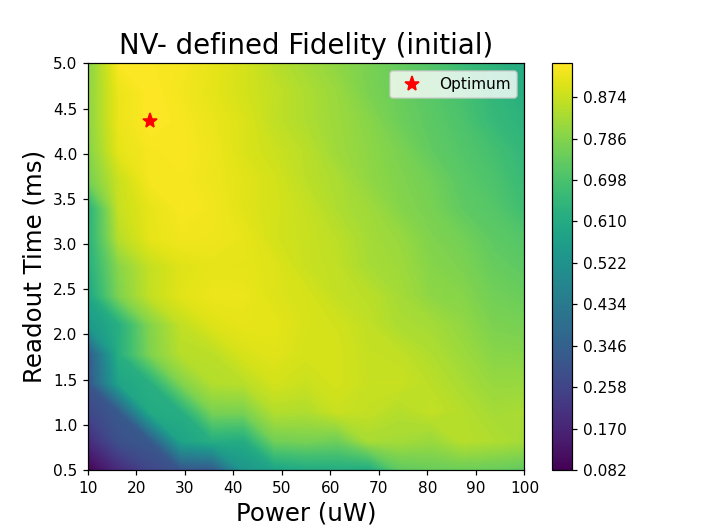

<IPython.core.display.Javascript object>


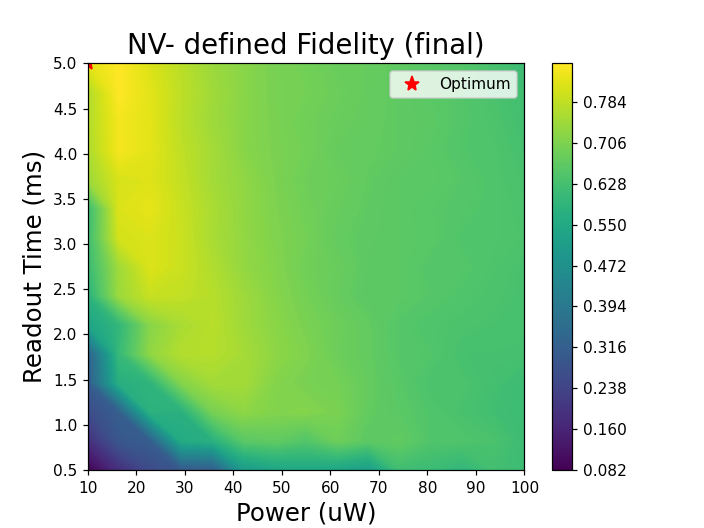

In [340]:
plt.figure(dpi=100)
plt.contourf(power*1000, time*1000, new_F_2d_i,500)
plt.title('NV- defined Fidelity (initial)', fontsize =18)
plt.plot(opt_p_i*1000, opt_t_i*1000, '*', ms=10, color='red', label='Optimum')
plt.xlabel('Power (uW)', fontsize=16)
plt.ylabel('Readout Time (ms)', fontsize =16)
#plt.yscale("log")
plt.colorbar()
plt.legend()
#plt.savefig("F_distinguish_initial_broad.png",dpi=150)

plt.figure(dpi=100)
plt.contourf(power*1000, time*1000, new_F_2d_f,500)
plt.title('NV- defined Fidelity (final)', fontsize =18)
plt.plot(opt_p_f*1000, opt_t_f*1000, '*', ms=10, color='red', label='Optimum')
plt.xlabel('Power (uW)', fontsize=16)
plt.ylabel('Readout Time (ms)', fontsize =16)
#plt.yscale("log")
plt.colorbar()
plt.legend()
#plt.savefig("F_distinguish_initial_broad.png",dpi=150)

0.25 0.75


C:\Users\majid\AppData\Local\Temp\ipykernel_14624\4007661050.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=100)


<IPython.core.display.Javascript object>


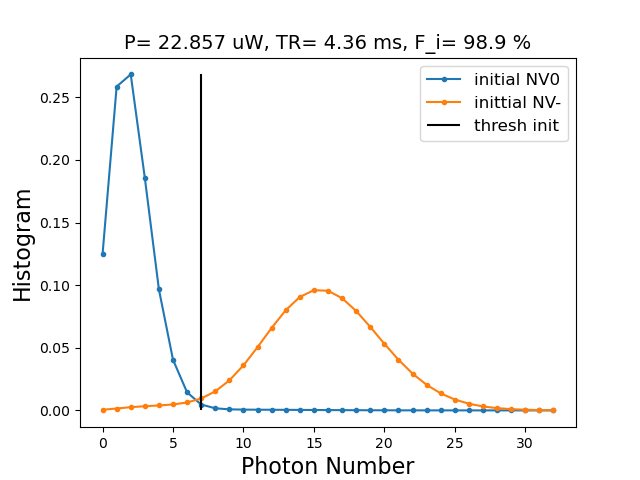

0.25 0.75


<IPython.core.display.Javascript object>


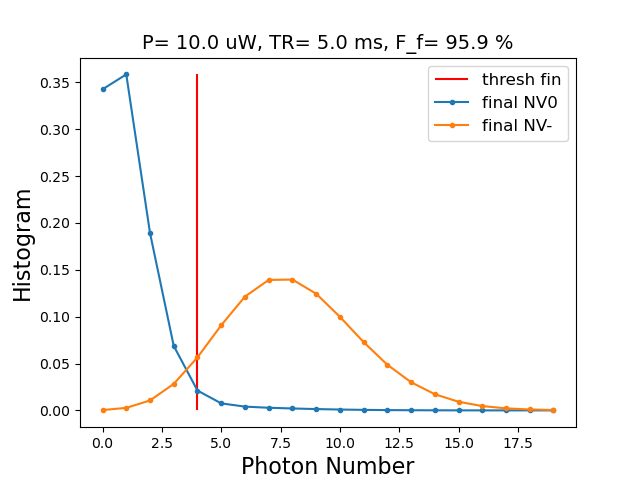

Text(0, 0.5, 'Histogram')

In [324]:
P = opt_p_i # mW
la1 = 20823.89228823*P  # cps
la2 = 160507.64200232*P # cps
ga1 = 3872.39255739*P*P    # Hz
ga2 = 24142.64150491 *P*P  # Hz
TR = opt_t_i  # Read out time is second
#p2 = ga1/(ga1+ga2)
p2 = 0.75
p1 = 1-p2
print(p1,p2)
[N, pn_1,pn_2, pn_i1,pn_i2, pn_f1, pn_f2, F_i, F_f, n_th_i, n_th_f] = Distribution(la1,la2,ga1,ga2,TR,p1,p2,m=0)
[F_i,F_f,n_th_i, n_th_f, new_F_i, new_F_f] = Fidelity_state2(la1,la2,ga1,ga2,TR,p1,p2,m=m)
plt.figure(dpi=100)
#plt.plot(N, pn_1, '-o', ms=3, label='NV0')
#plt.plot(N, pn_2, '-o', ms=3, label='NV-')
plt.plot(N, pn_i1, '-o', ms=3, label='initial NV0')
plt.plot(N, pn_i2, '-o', ms=3, label='inittial NV-')
plt.vlines(n_th_i+min(N),ymin=0, ymax=max(pn_i1), color='black',label='thresh init')
#plt.vlines(n_th_f+min(N),ymin=0, ymax=max(pn_i1), color='red',label='thresh fin')
#plt.plot(N, pn_f1, '-o', ms=3, label='final NV0')
#plt.plot(N, pn_f2, '-o', ms=3, label='final NV-')
plt.title('P= {} uW'.format(1e-3*round(P*1e6))+', TR= {} ms'.format(round(TR*1e5)*1e-2)
          +', F_i= {} %'.format(round(F_i*1e4)*1e-2), fontsize=14)
plt.legend(fontsize=12)
plt.xlabel('Photon Number', fontsize=16)
plt.ylabel('Histogram', fontsize=16)

P = opt_p_f # mW
la1 = 20823.89228823*P  # cps
la2 = 160507.64200232*P # cps
ga1 = 3872.39255739*P*P    # Hz
ga2 = 24142.64150491 *P*P  # Hz
TR = opt_t_f  # Read out time is second
#p2 = ga1/(ga1+ga2)
p2 = 0.75
p1 = 1-p2
print(p1,p2)
[N, pn_1,pn_2, pn_i1,pn_i2, pn_f1, pn_f2, F_i, F_f, n_th_i, n_th_f] = Distribution(la1,la2,ga1,ga2,TR,p1,p2,m=0)
[F_i,F_f,n_th_i, n_th_f, new_F_i, new_F_f] = Fidelity_state2(la1,la2,ga1,ga2,TR,p1,p2,m=m)
plt.figure(dpi=100)
#plt.plot(N, pn_1, '-o', ms=3, label='NV0')
#plt.plot(N, pn_2, '-o', ms=3, label='NV-')
#plt.plot(N, pn_i1, '-o', ms=3, label='initial NV0')
#plt.plot(N, pn_i2, '-o', ms=3, label='inittial NV-')
#plt.vlines(n_th_i+min(N),ymin=0, ymax=max(pn_i1), color='black',label='thresh init')
plt.vlines(n_th_f+min(N),ymin=0, ymax=max(pn_f1), color='red',label='thresh fin')
plt.plot(N, pn_f1, '-o', ms=3, label='final NV0')
plt.plot(N, pn_f2, '-o', ms=3, label='final NV-')
plt.title('P= {} uW'.format(1e-3*round(P*1e6))+', TR= {} ms'.format(round(TR*1e5)*1e-2)
          +', F_f= {} %'.format(round(F_f*1e3)*1e-1), fontsize=14)
plt.legend(fontsize=12)
plt.xlabel('Photon Number', fontsize=16)
plt.ylabel('Histogram', fontsize=16)


# Let's shift the threshold to get higher fidelities 

In [345]:
F_2d_i, F_2d_f,new_F_2d_i,new_F_2d_f = [], [],[], []
PP = np.linspace(0.01,0.1,15)
p1,p2 = 0.25, 0.75
m=2
for P in tqdm.tqdm_notebook(PP):
    la1 = 20823.89228823*P  # cps
    la2 = 160507.64200232*P # cps
    ga1 = 3872.39255739*P*P   # Hz
    ga2 = 24142.64150491*P*P  # Hz
    
    F_is,F_fs,new_F_is,new_F_fs=[], [],[], []
    TTR = np.linspace(0.5e-3,5e-3,15)
    for TR in TTR:
        [F_i,F_f,n_th_i, n_th_f, new_F_i, new_F_f] = Fidelity_state2(la1,la2,ga1,ga2,TR,p1,p2,m=m)
        F_is.append(F_i)
        F_fs.append(F_f)
        new_F_is.append(new_F_i)
        new_F_fs.append(new_F_f)
    
    F_2d_i.append(F_is)
    F_2d_f.append(F_fs)
    new_F_2d_i.append(new_F_is)
    new_F_2d_f.append(new_F_fs)
    
F_2d_i, F_2d_f,new_F_2d_i,new_F_2d_f = np.array(F_2d_i), np.array(F_2d_f),np.array(new_F_2d_i), np.array(new_F_2d_f)

C:\Users\majid\AppData\Local\Temp\ipykernel_14624\1289585641.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for P in tqdm.tqdm_notebook(PP):


  0%|          | 0/15 [00:00<?, ?it/s]

Max Fidelity init= 0.9998230175454883
Optimum power init = 10.0 uW
Optimum time init= 0.5 ms


<IPython.core.display.Javascript object>


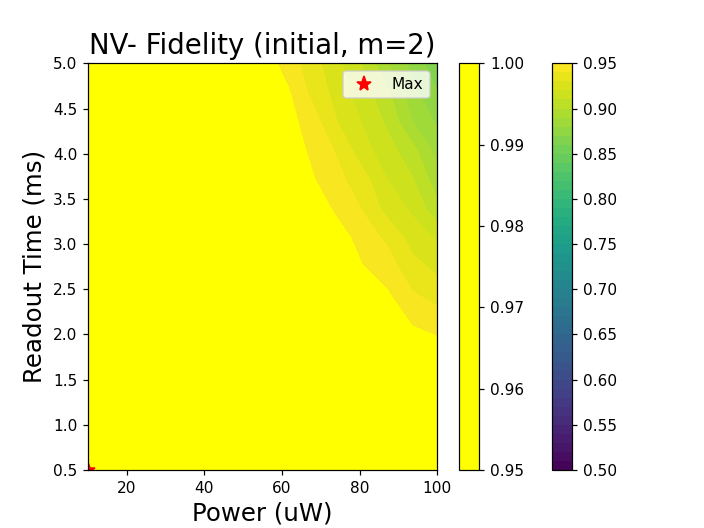

Max Fidelity final= 0.9997708902874418
Optimum power = 10.0 uW
Optimum time = 0.5 ms


C:\Users\majid\AppData\Local\Temp\ipykernel_14624\3939536463.py:20: UserWarning: linewidths is ignored by contourf
  plt.contourf(power*1000, time*1000,F_2d_i,


<IPython.core.display.Javascript object>


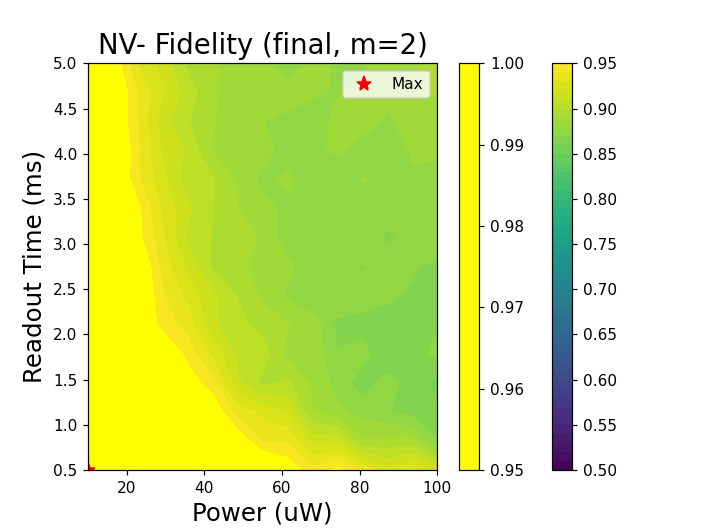

C:\Users\majid\AppData\Local\Temp\ipykernel_14624\3939536463.py:46: UserWarning: linewidths is ignored by contourf
  plt.contourf(power*1000, time*1000,F_2d_f,


In [346]:
time,power=np.meshgrid(TTR, PP)
opt_F_i, opt_F_f = np.max(F_2d_i),  np.max(F_2d_f)
print("Max Fidelity init= {}".format(opt_F_i))
#########################################################
result=np.where(F_2d_i == np.amax(F_2d_i))
listOfCordinates = list(zip(result[0], result[1]))
for cord in listOfCordinates:
    if F_2d_i[cord[0]][cord[1]]==np.max(F_2d_i):
        opt_p_i = power[cord[0]][cord[1]]
        opt_t_i = time[cord[0]][cord[1]]
        print('Optimum power init = {} uW'.format(opt_p_i*1000))
        print('Optimum time init= {} ms'.format(opt_t_i*1000))
    else: print('max did not calculated correctly')

#############################################################################
F_lim=0.95 #### What is your minimum required fidelity
plt.figure(dpi=100)
plt.contourf(power*1000, time*1000, F_2d_i,np.arange(0.5, F_lim+0.01, .01))
plt.colorbar()
plt.contourf(power*1000, time*1000,F_2d_i,
             levels = np.arange(F_lim, 1, .01), colors=('yellow',),linestyles=('-',),linewidths=(3,))
plt.colorbar()
plt.title('NV- Fidelity (initial, m={})'.format(m), fontsize =18)
plt.plot(opt_p_i*1000, opt_t_i*1000, '*', ms=10, color='red', label='Max')
plt.xlabel('Power (uW)', fontsize=16)
plt.ylabel('Readout Time (ms)', fontsize =16)
#plt.yscale("log")
plt.legend()
#plt.savefig("F_distinguish_initial_broad.png",dpi=150)

###################################################################
print( "Max Fidelity final= {}".format(opt_F_f))
result=np.where(F_2d_f == np.amax(F_2d_f))
listOfCordinates = list(zip(result[0], result[1]))
for cord in listOfCordinates:
    if F_2d_f[cord[0]][cord[1]]==np.max(F_2d_f):
        opt_p_f = power[cord[0]][cord[1]]
        opt_t_f = time[cord[0]][cord[1]]
        print('Optimum power = {} uW'.format(opt_p_f*1000))
        print('Optimum time = {} ms'.format(opt_t_i*1000))
    else: print('max did not calculated correctly')
#######################################################################
plt.figure(dpi=100)
plt.contourf(power*1000, time*1000, F_2d_f,np.arange(0.5, F_lim+0.01, .01))
plt.colorbar()
plt.contourf(power*1000, time*1000,F_2d_f,
             levels = np.arange(F_lim, 1, .01), colors=('yellow',),linestyles=('-',),linewidths=(3,))
plt.colorbar()
plt.title('NV- Fidelity (final, m={})'.format(m), fontsize =18)
plt.plot(opt_p_f*1000, opt_t_f*1000, '*', ms=10, color='red', label='Max')
plt.xlabel('Power (uW)', fontsize=16)
plt.ylabel('Readout Time (ms)', fontsize =16)
plt.legend()
#plt.yscale("log")
#plt.savefig("F_distinguish_final_broad.png",dpi=150)


Max Fidelity init= 0.9998230175454883
Optimum power init = 10.0 uW
Optimum time init= 0.5 ms


<IPython.core.display.Javascript object>


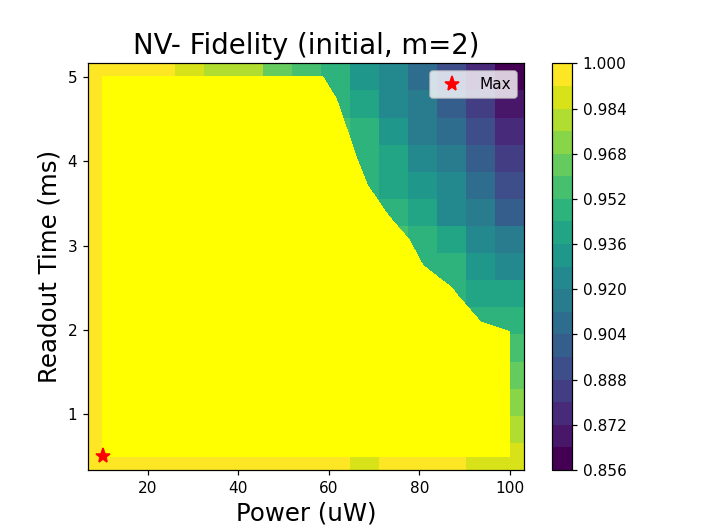

Max Fidelity final= 0.9997708902874418
Optimum power = 10.0 uW
Optimum time = 0.5 ms


C:\Users\majid\AppData\Local\Temp\ipykernel_14624\3127813189.py:29: UserWarning: linewidths is ignored by contourf
  plt.contourf(power*1000, time*1000,z,


<IPython.core.display.Javascript object>


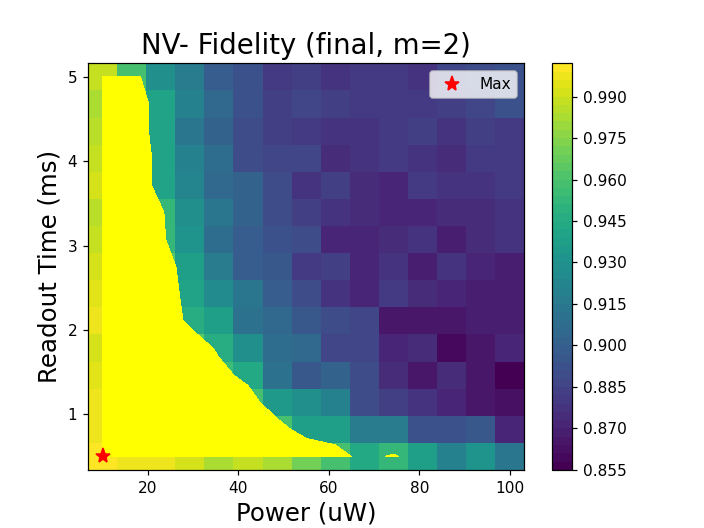

C:\Users\majid\AppData\Local\Temp\ipykernel_14624\3127813189.py:59: UserWarning: linewidths is ignored by contourf
  plt.contourf(power*1000, time*1000,z,


In [347]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

time,power=np.meshgrid(TTR, PP)
opt_F_i, opt_F_f = np.max(F_2d_i),  np.max(F_2d_f)
print("Max Fidelity init= {}".format(opt_F_i))
z=F_2d_i
#########################################################
result=np.where(z == np.amax(z))
listOfCordinates = list(zip(result[0], result[1]))
for cord in listOfCordinates:
    if z[cord[0]][cord[1]]==np.max(z):
        opt_p_i = power[cord[0]][cord[1]]
        opt_t_i = time[cord[0]][cord[1]]
        print('Optimum power init = {} uW'.format(opt_p_i*1000))
        print('Optimum time init= {} ms'.format(opt_t_i*1000))
    else: print('max did not calculated correctly')

#############################################################################
F_lim=0.95 #### What is your minimum required fidelity
plt.figure(dpi=100)
levels = MaxNLocator(nbins=20).tick_values(z.min(), z.max())
cmap = plt.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
plt.pcolormesh(power*1000, time*1000, z, norm=norm)
plt.colorbar()
plt.contourf(power*1000, time*1000,z,
             levels = np.arange(F_lim, 1, .01), colors=('yellow',),linestyles=('-',),linewidths=(3,))
plt.title('NV- Fidelity (initial, m={})'.format(m), fontsize =18)
plt.plot(opt_p_i*1000, opt_t_i*1000, '*', ms=10, color='red', label='Max')
plt.xlabel('Power (uW)', fontsize=16)
plt.ylabel('Readout Time (ms)', fontsize =16)
#plt.yscale("log")
plt.legend()
#plt.savefig("F_distinguish_initial_broad.png",dpi=150)

###################################################################
z=F_2d_f
print( "Max Fidelity final= {}".format(opt_F_f))
result=np.where(z == np.amax(z))
listOfCordinates = list(zip(result[0], result[1]))
for cord in listOfCordinates:
    if z[cord[0]][cord[1]]==np.max(z):
        opt_p_f = power[cord[0]][cord[1]]
        opt_t_f = time[cord[0]][cord[1]]
        print('Optimum power = {} uW'.format(opt_p_f*1000))
        print('Optimum time = {} ms'.format(opt_t_i*1000))
    else: print('max did not calculated correctly')
#######################################################################
F_lim=0.95 #### What is your minimum required fidelity
plt.figure(dpi=100)
levels = MaxNLocator(nbins=50).tick_values(z.min(), z.max())
cmap = plt.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
plt.pcolormesh(power*1000, time*1000, z, norm=norm)
plt.colorbar()
plt.contourf(power*1000, time*1000,z,
             levels = np.arange(F_lim, 1, .01), colors=('yellow',),linestyles=('-',),linewidths=(3,))
plt.title('NV- Fidelity (final, m={})'.format(m), fontsize =18)
plt.plot(opt_p_f*1000, opt_t_f*1000, '*', ms=10, color='red', label='Max')
plt.xlabel('Power (uW)', fontsize=16)
plt.ylabel('Readout Time (ms)', fontsize =16)
plt.legend()
#plt.yscale("log")
#plt.savefig("F_distinguish_final_broad.png",dpi=150)


0.25 0.75


<IPython.core.display.Javascript object>


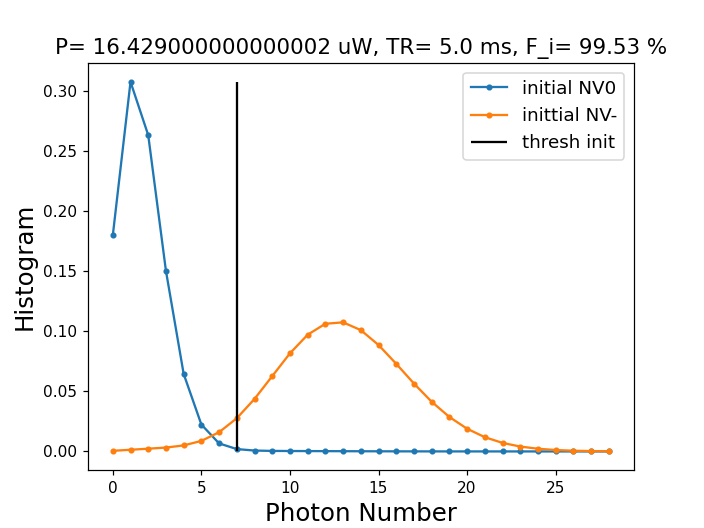

0.25 0.75


<IPython.core.display.Javascript object>


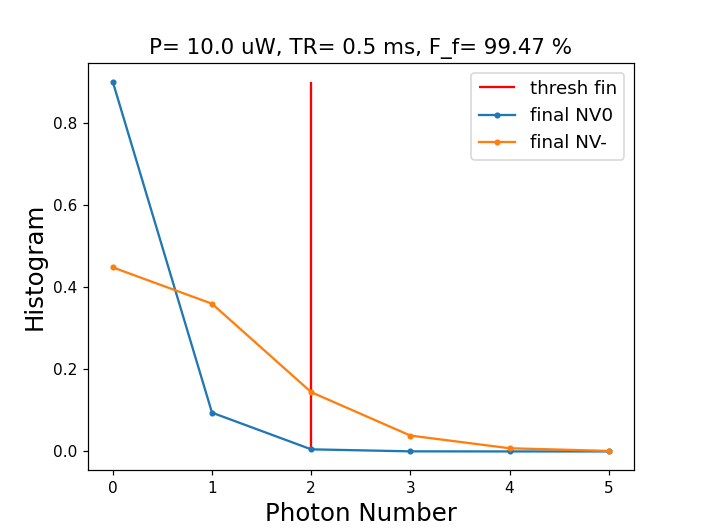

Text(0, 0.5, 'Histogram')

In [344]:
P = opt_p_i # mW
la1 = 20823.89228823*P  # cps
la2 = 160507.64200232*P # cps
ga1 = 3872.39255739*P*P    # Hz
ga2 = 24142.64150491 *P*P  # Hz
TR = opt_t_i  # Read out time is second
#p2 = ga1/(ga1+ga2)
p2 = 0.75
p1 = 1-p2
print(p1,p2)
[N, pn_1,pn_2, pn_i1,pn_i2, pn_f1, pn_f2, F_i, F_f, n_th_i, n_th_f] = Distribution(la1,la2,ga1,ga2,TR,p1,p2,m=0)
[F_i,F_f,n_th_i, n_th_f, new_F_i, new_F_f] = Fidelity_state2(la1,la2,ga1,ga2,TR,p1,p2,m=m)
plt.figure(dpi=100)
#plt.plot(N, pn_1, '-o', ms=3, label='NV0')
#plt.plot(N, pn_2, '-o', ms=3, label='NV-')
plt.plot(N, pn_i1, '-o', ms=3, label='initial NV0')
plt.plot(N, pn_i2, '-o', ms=3, label='inittial NV-')
plt.vlines(n_th_i+min(N),ymin=0, ymax=max(pn_i1), color='black',label='thresh init')
#plt.vlines(n_th_f+min(N),ymin=0, ymax=max(pn_i1), color='red',label='thresh fin')
#plt.plot(N, pn_f1, '-o', ms=3, label='final NV0')
#plt.plot(N, pn_f2, '-o', ms=3, label='final NV-')
plt.title('P= {} uW'.format(1e-3*round(P*1e6))+', TR= {} ms'.format(round(TR*1e5)*1e-2)
          +', F_i= {} %'.format(round(F_i*1e4)*1e-2), fontsize=14)
plt.legend(fontsize=12)
plt.xlabel('Photon Number', fontsize=16)
plt.ylabel('Histogram', fontsize=16)

P = opt_p_f # mW
la1 = 20823.89228823*P  # cps
la2 = 160507.64200232*P # cps
ga1 = 3872.39255739*P*P    # Hz
ga2 = 24142.64150491 *P*P  # Hz
TR = opt_t_f  # Read out time is second
#p2 = ga1/(ga1+ga2)
p2 = 0.75
p1 = 1-p2
print(p1,p2)
[N, pn_1,pn_2, pn_i1,pn_i2, pn_f1, pn_f2, F_i, F_f, n_th_i, n_th_f] = Distribution(la1,la2,ga1,ga2,TR,p1,p2,m=0)
[F_i,F_f,n_th_i, n_th_f, new_F_i, new_F_f] = Fidelity_state2(la1,la2,ga1,ga2,TR,p1,p2,m=m)
plt.figure(dpi=100)
#plt.plot(N, pn_1, '-o', ms=3, label='NV0')
#plt.plot(N, pn_2, '-o', ms=3, label='NV-')
#plt.plot(N, pn_i1, '-o', ms=3, label='initial NV0')
#plt.plot(N, pn_i2, '-o', ms=3, label='inittial NV-')
#plt.vlines(n_th_i+min(N),ymin=0, ymax=max(pn_i1), color='black',label='thresh init')
plt.vlines(n_th_f+min(N),ymin=0, ymax=max(pn_f1), color='red',label='thresh fin')
plt.plot(N, pn_f1, '-o', ms=3, label='final NV0')
plt.plot(N, pn_f2, '-o', ms=3, label='final NV-')
plt.title('P= {} uW'.format(1e-3*round(P*1e6))+', TR= {} ms'.format(round(TR*1e5)*1e-2)
          +', F_f= {} %'.format(round(F_f*1e4)*1e-2), fontsize=14)
plt.legend(fontsize=12)
plt.xlabel('Photon Number', fontsize=16)
plt.ylabel('Histogram', fontsize=16)


# Average number of attempts

In [350]:
def integrand_P_even_jump(t,la1,la2,ga1,ga2,TR):
    return exp((ga1-ga2)*t-ga1*TR)*sqrt(ga1*ga2*t/(TR-t))*iv(1,2*sqrt(ga1*ga2*t*(TR-t)))*1
    
def P_even_jump(la1,la2,ga1,ga2,TR): # probability to emit n photons for even jumps FROM LEVEL 2 TO LEVEL 1
    return quad(integrand_P_even_jump, 0, TR, args=(la1,la2,ga1,ga2,TR))[0] + exp(-ga2*TR)*1

##########################################################################################################
def integrand_P_odd_jump(t,la1,la2,ga1,ga2,TR):
    return exp((ga1-ga2)*t-ga1*TR)*ga2*iv(0,2*sqrt(ga1*ga2*t*(TR-t)))*1
    
def P_odd_jump(la1,la2,ga1,ga2,TR): # probability to emit n photons for odd jumps FROM LEVEL 2 TO LEVEL 1
    return quad(integrand_P_odd_jump, 0, TR, args=(la1,la2,ga1,ga2,TR))[0]
#########################################################################################################################

def Succ_P(la1,la2,ga1,ga2,TR,p1,p2,m): # p= population of initial state, pf = population of final state
    pn_f1,pn_f2,pn_i1,pn_i2 =np.array([]), np.array([]),np.array([]), np.array([])
    N = np.arange(poisson.ppf(0.0001, la1*TR),poisson.ppf(0.9999, la2*TR)) ### trancating the fidelity integral
    for n in N:
        even_from2 = Pn_even(n,la1,la2,ga1,ga2,TR)
        odd_from2 = Pn_odd(n,la1,la2,ga1,ga2,TR)
        even_from1 = Pn_even(n,la2,la1,ga2,ga1,TR)
        odd_from1 = Pn_odd(n,la2,la1,ga2,ga1,TR)
        
        pn_i1 = np.append(pn_i1, even_from1+odd_from1)        # probab. to emit n photons conditioned initial state 1
        pn_i2 = np.append(pn_i2, even_from2+odd_from2) 
        pn_f1 = np.append(pn_f1, p2*odd_from2 +p1*even_from1) # probab. to emit n photons conditioned final state 1
        pn_f2 = np.append(pn_f2, p2*even_from2 +p1*odd_from1) # probab. to emit n photons conditioned final state 2
    
    pn_f1, pn_f2 = pn_f1/np.sum(pn_f1), pn_f2/np.sum(pn_f2)
    n_th_f, n_th_i = n_th(pn_f1,pn_f2)+m,  n_th(pn_i1,pn_i2)+m 
    pf2= p1*P_odd_jump(la2,la1,ga2,ga1,TR)+p2*P_even_jump(la1,la2,ga1,ga2,TR)
    pf1= p2*P_odd_jump(la1,la2,ga1,ga2,TR)+p1*P_even_jump(la2,la1,ga2,ga1,TR)
    pf2=pf2/(pf1+pf2)
    pf1=1-pf2

    succ_P_f = pf2*np.sum(pn_f2[n_th_f:]) + pf1* np.sum(pn_f1[n_th_f:]) # based on final distributions
    succ_P_i = p2*np.sum(pn_i2[n_th_i:]) + p1* np.sum(pn_i1[n_th_i:]) # based on initial distributions
    #print(succ_P, succ_P1) They are the same!
    return 1/succ_P_i

def Succ_time(la1,la2,ga1,ga2,TR,p1,p2,m): #### time is in terms of seconds
    return(TR*Succ_P(la1,la2,ga1,ga2,TR,p1,p2,m))

# Calculating final population of NV- for green

In [351]:
P = 0.01 # mW
la1 = 20823.89228823*P  # cps
la2 = 160507.64200232*P # cps
ga1 = 3872.39255739*P*P    # Hz
ga2 = 24142.64150491 *P*P  # Hz
TR = opt_t_i*1  # Read out time is second
p2 = ga1/(ga1+ga2)
p2 = 0.75
p1 = 1-p2

pf2= p1*P_odd_jump(la2,la1,ga2,ga1,TR)+p2*P_even_jump(la1,la2,ga1,ga2,TR)
pf1= p2*P_odd_jump(la1,la2,ga1,ga2,TR)+p1*P_even_jump(la2,la1,ga2,ga1,TR)
pf2=pf2/(pf1+pf2)
pf1=1-pf2

print(Succ_P(la1,la2,ga1,ga2,TR,1-0.1382,0.1382,m))
print(Succ_P(la1,la2,ga1,ga2,TR,p1,p2,m))

148.68585791045015
27.9988668888343


In [395]:
n_att_or, n_att_gr = [], []
PP = np.linspace(0.01,0.1,15)
m=2
for P in tqdm.tqdm_notebook(PP):
    la1 = 20823.89228823*P  # cps
    la2 = 160507.64200232*P # cps
    ga1 = 3872.39255739*P*P   # Hz
    ga2 = 24142.64150491*P*P  # Hz
    
    F_or,F_gr=[], []
    TTR = np.linspace(0.5e-3,5e-3,15)
    for TR in TTR:
        succ_P_or = Succ_P(la1,la2,ga1,ga2,TR,ga2/(ga1+ga2),ga1/(ga1+ga2),m)
        succ_P_gr = Succ_P(la1,la2,ga1,ga2,TR,0.25,0.75,m)
        F_or.append(succ_P_or)
        F_gr.append(succ_P_gr)
    
    n_att_or.append(F_or)
    n_att_gr.append(F_gr)
    
n_att_or, n_att_gr = np.array(n_att_or), np.array(n_att_gr)

C:\Users\majid\AppData\Local\Temp\ipykernel_14624\2358068498.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for P in tqdm.tqdm_notebook(PP):


  0%|          | 0/15 [00:00<?, ?it/s]

Optimum power init = 10.0 uW
Optimum time init= 0.5 ms


<IPython.core.display.Javascript object>


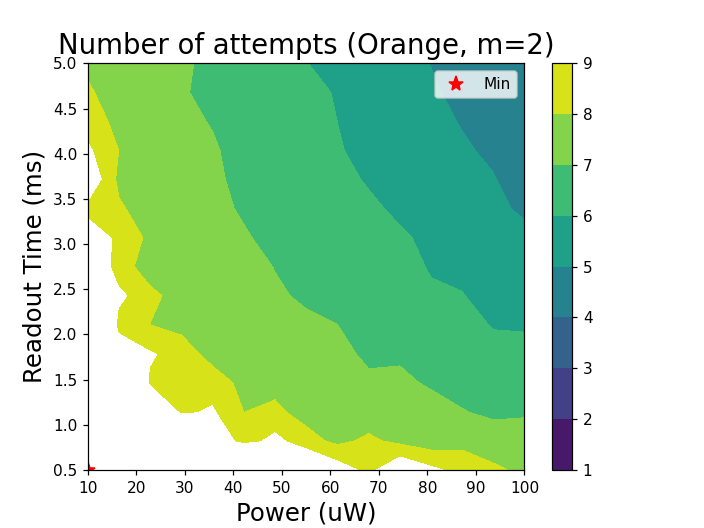

Max Fidelity final= 0.9997708902874418
Optimum power = 10.0 uW
Optimum time = 0.5 ms


<IPython.core.display.Javascript object>


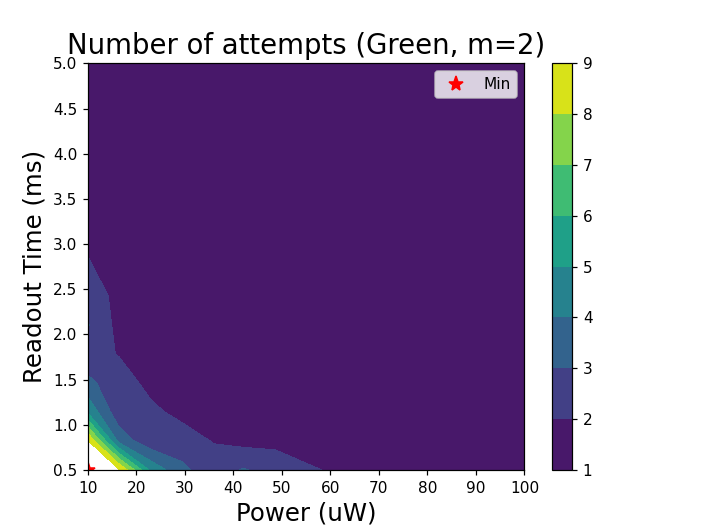

In [354]:
time,power=np.meshgrid(TTR, PP)
#########################################################
result=np.where(n_att_or == np.amax(n_att_or))
listOfCordinates = list(zip(result[0], result[1]))
for cord in listOfCordinates:
    if n_att_or[cord[0]][cord[1]]==np.max(n_att_or):
        opt_p_i = power[cord[0]][cord[1]]
        opt_t_i = time[cord[0]][cord[1]]
        print('Optimum power init = {} uW'.format(opt_p_i*1000))
        print('Optimum time init= {} ms'.format(opt_t_i*1000))
    else: print('max did not calculated correctly')

#############################################################################
F_lim=0.95 #### What is your minimum required fidelity
plt.figure(dpi=100)
plt.contourf(power*1000, time*1000, n_att_or,np.arange(1,10,1))
plt.colorbar()
#plt.contourf(power*1000, time*1000,n_att_or,
#             levels = np.arange(F_lim, 1, .01), colors=('yellow',),linestyles=('-',),linewidths=(3,))
#plt.colorbar()
plt.title('Number of attempts (Orange, m={})'.format(m), fontsize =18)
plt.plot(opt_p_i*1000, opt_t_i*1000, '*', ms=10, color='red', label='Min')
plt.xlabel('Power (uW)', fontsize=16)
plt.ylabel('Readout Time (ms)', fontsize =16)
#plt.yscale("log")
plt.legend()
#plt.savefig("F_distinguish_initial_broad.png",dpi=150)

###################################################################
print( "Max Fidelity final= {}".format(opt_F_f))
result=np.where(n_att_gr == np.amax(n_att_gr))
listOfCordinates = list(zip(result[0], result[1]))
for cord in listOfCordinates:
    if n_att_gr[cord[0]][cord[1]]==np.max(n_att_gr):
        opt_p_f = power[cord[0]][cord[1]]
        opt_t_f = time[cord[0]][cord[1]]
        print('Optimum power = {} uW'.format(opt_p_f*1000))
        print('Optimum time = {} ms'.format(opt_t_i*1000))
    else: print('max did not calculated correctly')
#######################################################################
plt.figure(dpi=100)
plt.contourf(power*1000, time*1000, n_att_gr,np.arange(1,10,1))
plt.colorbar()
#plt.contourf(power*1000, time*1000,n_att_gr,
#             levels = np.arange(F_lim, 1, .01), colors=('yellow',),linestyles=('-',),linewidths=(3,))
#plt.colorbar()
plt.title('Number of attempts (Green, m={})'.format(m), fontsize =18)
plt.plot(opt_p_f*1000, opt_t_f*1000, '*', ms=10, color='red', label='Min')
plt.xlabel('Power (uW)', fontsize=16)
plt.ylabel('Readout Time (ms)', fontsize =16)
plt.legend()
#plt.yscale("log")
#plt.savefig("F_distinguish_final_broad.png",dpi=150)


Optimum power init = 100.0 uW
Optimum time init= 5.0 ms


<IPython.core.display.Javascript object>


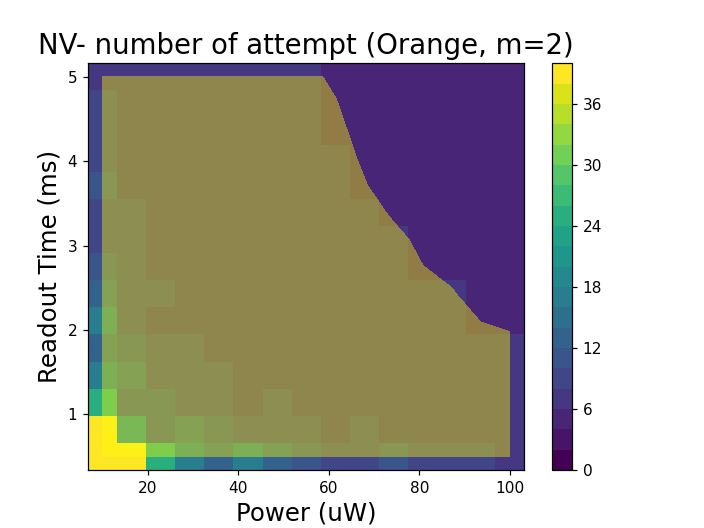

Max Fidelity final= 0.9997708902874418
Optimum power = 22.85714285714286 uW
Optimum time = 5.0 ms


<IPython.core.display.Javascript object>


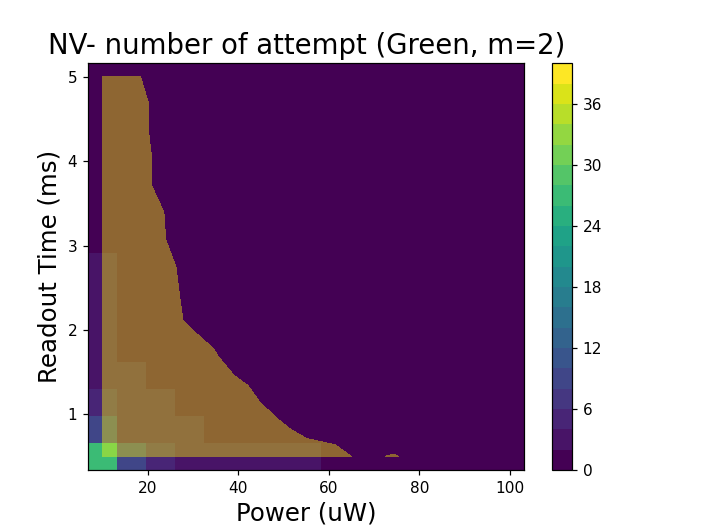

Text(0, 0.5, 'Readout Time (ms)')

In [398]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

z=n_att_or
#########################################################
result=np.where(z == np.amin(z))
listOfCordinates = list(zip(result[0], result[1]))
for cord in listOfCordinates:
    if z[cord[0]][cord[1]]==np.min(z):
        opt_p_i = power[cord[0]][cord[1]]
        opt_t_i = time[cord[0]][cord[1]]
        print('Optimum power init = {} uW'.format(opt_p_i*1000))
        print('Optimum time init= {} ms'.format(opt_t_i*1000))
    else: print('min did not calculated correctly')

#############################################################################
F_lim=0.95 #### What is your minimum required fidelity
plt.figure(dpi=100)
levels = MaxNLocator(nbins=20).tick_values(1, 40)
cmap = plt.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
plt.pcolormesh(power*1000, time*1000, n_att_or, norm=norm)
plt.colorbar()
plt.contourf(power*1000, time*1000,F_2d_i,levels = np.arange(F_lim, 1, .05), colors=('yellow',),alpha=0.4)
plt.title('NV- number of attempt (Orange, m={})'.format(m), fontsize =18)
#plt.plot(opt_p_i*1000, opt_t_i*1000, '*', ms=10, color='red', label='Min')
plt.xlabel('Power (uW)', fontsize=16)
plt.ylabel('Readout Time (ms)', fontsize =16)
#plt.yscale("log")
#plt.legend()
#plt.savefig("F_distinguish_initial_broad.png",dpi=150)

###################################################################
z=n_att_gr
print( "Max Fidelity final= {}".format(opt_F_f))
result=np.where(z == np.amin(z))
listOfCordinates = list(zip(result[0], result[1]))
for cord in listOfCordinates:
    if z[cord[0]][cord[1]]==np.min(z):
        opt_p_f = power[cord[0]][cord[1]]
        opt_t_f = time[cord[0]][cord[1]]
        print('Optimum power = {} uW'.format(opt_p_f*1000))
        print('Optimum time = {} ms'.format(opt_t_i*1000))
    else: print('max did not calculated correctly')
#######################################################################
F_lim=0.95 #### What is your minimum required fidelity
plt.figure(dpi=100)
levels = MaxNLocator(nbins=20).tick_values(1, 40)
cmap = plt.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
plt.pcolormesh(power*1000, time*1000, z, norm=norm)
plt.colorbar()
plt.contourf(power*1000, time*1000,F_2d_f,levels = np.arange(F_lim, 1, .05), colors=('yellow',), alpha=0.4)
plt.title('NV- number of attempt (Green, m={})'.format(m), fontsize =18)
#plt.plot(opt_p_f*1000, opt_t_f*1000, '*', ms=10, color='red', label='Min')
plt.xlabel('Power (uW)', fontsize=16)
plt.ylabel('Readout Time (ms)', fontsize =16)
#plt.legend()
#plt.yscale("log")
#plt.savefig("F_distinguish_final_broad.png",dpi=150)

# Optimizing time

In [383]:
time_or, time_gr = [], []
PP = np.linspace(0.01,0.1,15)
m=2
for P in tqdm.tqdm_notebook(PP):
    la1 = 20823.89228823*P  # cps
    la2 = 160507.64200232*P # cps
    ga1 = 3872.39255739*P*P   # Hz
    ga2 = 24142.64150491*P*P  # Hz
    
    F_or,F_gr=[], []
    TTR = np.linspace(0.5e-3,5e-3,15)
    for TR in TTR:
        succ_P_or = Succ_time(la1,la2,ga1,ga2,TR,ga2/(ga1+ga2),ga1/(ga1+ga2),m)
        succ_P_gr = Succ_time(la1,la2,ga1,ga2,TR,0.25,0.75,m)
        F_or.append(succ_P_or)
        F_gr.append(succ_P_gr)
    
    time_or.append(F_or)
    time_gr.append(F_gr)
    
time_or, time_gr = np.array(time_or), np.array(time_gr)

C:\Users\majid\AppData\Local\Temp\ipykernel_14624\2961282029.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for P in tqdm.tqdm_notebook(PP):


  0%|          | 0/15 [00:00<?, ?it/s]

In [387]:
np.max(time_or)

0.07432956620397907

Max Fidelity init= 0.07431596044355976
Optimum power init = 10.0 uW
Optimum time init= 0.5 ms


<IPython.core.display.Javascript object>


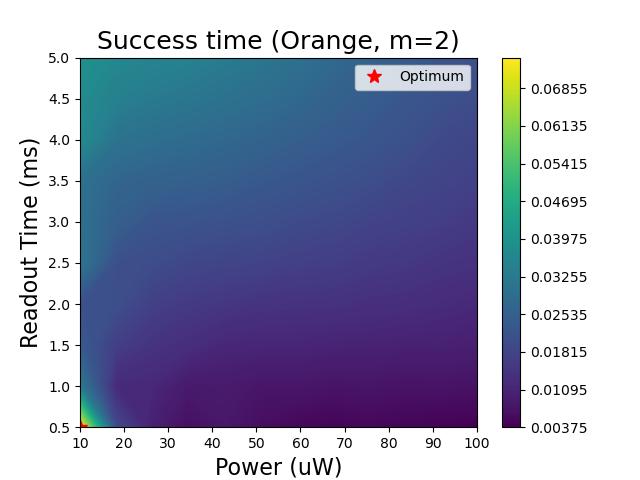

Max Fidelity final= 0.016078902712000114
Optimum power = 100.0 uW
Optimum time = 0.5 ms


<IPython.core.display.Javascript object>


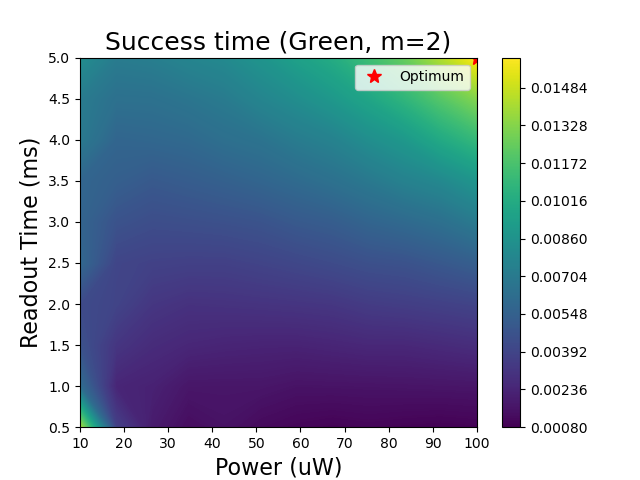

In [291]:

#########################################################
result=np.where(time_or == np.amax(time_or))
listOfCordinates = list(zip(result[0], result[1]))
for cord in listOfCordinates:
    if time_or[cord[0]][cord[1]]==np.max(time_or):
        opt_p_i = power[cord[0]][cord[1]]
        opt_t_i = time[cord[0]][cord[1]]
        print('Optimum power init = {} uW'.format(opt_p_i*1000))
        print('Optimum time init= {} ms'.format(opt_t_i*1000))
    else: print('max did not calculated correctly')

#############################################################################
F_lim=0.95 #### What is your minimum required fidelity
plt.figure(dpi=100)
plt.contourf(power*1000, time*1000, time_or,500)
plt.colorbar()
#plt.contourf(power*1000, time*1000,time_or,
#             levels = np.arange(F_lim, 1, .01), colors=('yellow',),linestyles=('-',),linewidths=(3,))
#plt.colorbar()
plt.title('Success time (Orange, m={})'.format(m), fontsize =18)
plt.plot(opt_p_i*1000, opt_t_i*1000, '*', ms=10, color='red', label='Optimum')
plt.xlabel('Power (uW)', fontsize=16)
plt.ylabel('Readout Time (ms)', fontsize =16)
#plt.yscale("log")
plt.legend()
#plt.savefig("F_distinguish_initial_broad.png",dpi=150)

###################################################################
result=np.where(time_gr == np.amax(time_gr))
listOfCordinates = list(zip(result[0], result[1]))
for cord in listOfCordinates:
    if time_gr[cord[0]][cord[1]]==np.max(time_gr):
        opt_p_f = power[cord[0]][cord[1]]
        opt_t_f = time[cord[0]][cord[1]]
        print('Optimum power = {} uW'.format(opt_p_f*1000))
        print('Optimum time = {} ms'.format(opt_t_i*1000))
    else: print('max did not calculated correctly')
#######################################################################
plt.figure(dpi=100)
plt.contourf(power*1000, time*1000, time_gr,500)
plt.colorbar()
#plt.contourf(power*1000, time*1000,time_gr,
#             levels = np.arange(F_lim, 1, .01), colors=('yellow',),linestyles=('-',),linewidths=(3,))
#plt.colorbar()
plt.title('Success time (Green, m={})'.format(m), fontsize =18)
plt.plot(opt_p_f*1000, opt_t_f*1000, '*', ms=10, color='red', label='Optimum')
plt.xlabel('Power (uW)', fontsize=16)
plt.ylabel('Readout Time (ms)', fontsize =16)
plt.legend()
#plt.yscale("log")
#plt.savefig("F_distinguish_final_broad.png",dpi=150)


Optimum power init = 100.0 uW
Optimum time init= 0.5 ms


<IPython.core.display.Javascript object>


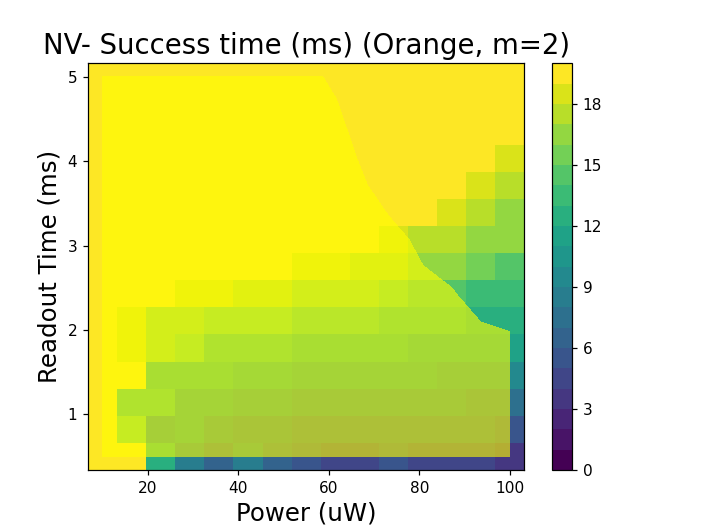

Max Fidelity final= 0.9997708902874418
Optimum power = 100.0 uW
Optimum time = 0.5 ms


<IPython.core.display.Javascript object>


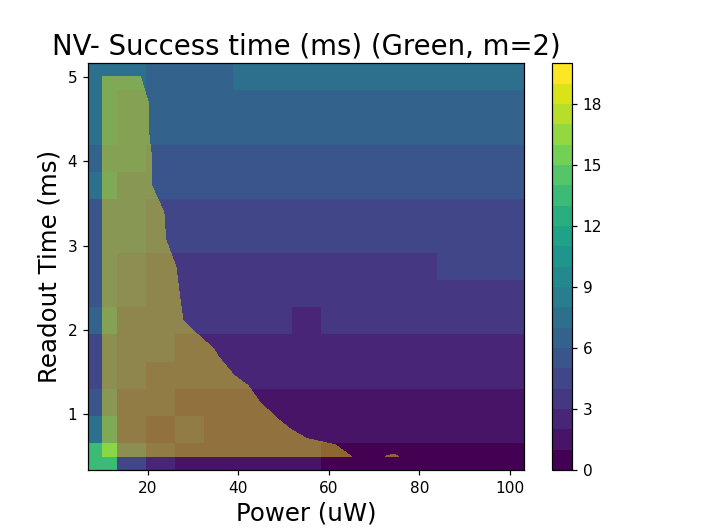

Text(0, 0.5, 'Readout Time (ms)')

In [394]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

z=time_or*1000 # from second to ms
#########################################################
result=np.where(z == np.amin(z))
listOfCordinates = list(zip(result[0], result[1]))
for cord in listOfCordinates:
    if z[cord[0]][cord[1]]==np.min(z):
        opt_p_i = power[cord[0]][cord[1]]
        opt_t_i = time[cord[0]][cord[1]]
        print('Optimum power init = {} uW'.format(opt_p_i*1000))
        print('Optimum time init= {} ms'.format(opt_t_i*1000))
    else: print('min did not calculated correctly')

#############################################################################
F_lim=0.95 #### What is your minimum required fidelity
plt.figure(dpi=100)
levels = MaxNLocator(nbins=20).tick_values(0.7, 20)
cmap = plt.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
plt.pcolormesh(power*1000, time*1000, z, norm=norm)
plt.colorbar()
plt.contourf(power*1000, time*1000,F_2d_i,levels = np.arange(F_lim, 1, .05), colors=('yellow',),alpha=0.6)
plt.title('NV- Success time (ms) (Orange, m={})'.format(m), fontsize =18)
#plt.plot(opt_p_i*1000, opt_t_i*1000, '*', ms=10, color='red', label='Min')
plt.xlabel('Power (uW)', fontsize=16)
plt.ylabel('Readout Time (ms)', fontsize =16)
#plt.yscale("log")
#plt.legend()
#plt.savefig("F_distinguish_initial_broad.png",dpi=150)

###################################################################
z=time_gr*1000
print( "Max Fidelity final= {}".format(opt_F_f))
result=np.where(z == np.amin(z))
listOfCordinates = list(zip(result[0], result[1]))
for cord in listOfCordinates:
    if z[cord[0]][cord[1]]==np.min(z):
        opt_p_f = power[cord[0]][cord[1]]
        opt_t_f = time[cord[0]][cord[1]]
        print('Optimum power = {} uW'.format(opt_p_f*1000))
        print('Optimum time = {} ms'.format(opt_t_i*1000))
    else: print('max did not calculated correctly')
#######################################################################
F_lim=0.95 #### What is your minimum required fidelity
plt.figure(dpi=100)
levels = MaxNLocator(nbins=20).tick_values(0.7, 20)
cmap = plt.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
plt.pcolormesh(power*1000, time*1000, z, norm=norm)
plt.colorbar()
plt.contourf(power*1000, time*1000,F_2d_f,levels = np.arange(F_lim, 1, .05), colors=('yellow',), alpha=0.4)
plt.title('NV- Success time (ms) (Green, m={})'.format(m), fontsize =18)
#plt.plot(opt_p_f*1000, opt_t_f*1000, '*', ms=10, color='red', label='Min')
plt.xlabel('Power (uW)', fontsize=16)
plt.ylabel('Readout Time (ms)', fontsize =16)
#plt.legend()
#plt.yscale("log")
#plt.savefig("F_distinguish_final_broad.png",dpi=150)